# Evaluation Notebook 

In [1]:
%load_ext autoreload
%autoreload 2
import json
from gensim.summarization.bm25 import BM25
from gensim.models.phrases import Phrases, Phraser
import pandas as pd
pd.set_option('display.max_columns', None)  
pd.set_option('display.expand_frame_repr', False)
pd.set_option('max_colwidth', 1000)
import numpy as np
from multiprocessing import Pool
from functools import partial
import matplotlib.pyplot as plt
import spacy
import seaborn as sns
sns.set()


from tqdm.notebook import tqdm
import warnings
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    tqdm.pandas()

import sys
import logging
logging.basicConfig(level=logging.INFO, stream=sys.stdout)


from bm25_retrieval import BM25Retrieval
from evaluation import *
from preprocessing import apply_pipeline, Corpus, BasicPreprocessing, BigramPreprocessor, SpacyPreprocessor

#### Load corpus using different preprocessing pipelines

In [2]:
base_file =  "../data/kit_expert_2017_papers.csv"

p = [BasicPreprocessing()]
papers_basic = Corpus(base_file, p)

p = [BasicPreprocessing(), BigramPreprocessor()]
papers_basic_bigram = Corpus(base_file, p)

p = [BasicPreprocessing(), SpacyPreprocessor(lemmatization=True)]
papers_basic_lemmatization = Corpus(base_file, p, load_from_cache=True)

p = [BasicPreprocessing(), SpacyPreprocessor(lemmatization=True), BigramPreprocessor()]
papers_basic_lemmatization_bigram = Corpus(base_file, p)

# p = [BasicPreprocessing(), SpacyPreprocessor(combine_noun_chunks=True)]
# papers_basic_nounchunk = Corpus(base_file, p)

# p = [BasicPreprocessing(), SpacyPreprocessor(lemmatization=True, combine_noun_chunks=True)] 
# papers_basic_lemmatization_nounchunk = Corpus(base_file, p)

INFO:preprocessing.pipeline:Start preprocessing pipeline "basic" for file ../data/kit_expert_2017_papers.csv.
INFO:preprocessing.pipeline:Loaded cached preprocessed corpus from ../data/kit_expert_2017_papers_basic
INFO:preprocessing.pipeline:Start preprocessing pipeline "basic_bigrams" for file ../data/kit_expert_2017_papers.csv.
INFO:preprocessing.pipeline:Loaded cached preprocessed corpus from ../data/kit_expert_2017_papers_basic_bigrams
INFO:preprocessing.pipeline:Start preprocessing pipeline "basic_spacy_lemmatization" for file ../data/kit_expert_2017_papers.csv.
INFO:preprocessing.pipeline:Loaded cached preprocessed corpus from ../data/kit_expert_2017_papers_basic_spacy_lemmatization
INFO:preprocessing.pipeline:Start preprocessing pipeline "basic_spacy_lemmatization_bigrams" for file ../data/kit_expert_2017_papers.csv.
INFO:preprocessing.pipeline:Loaded cached preprocessed corpus from ../data/kit_expert_2017_papers_basic_spacy_lemmatization_bigrams


#### Load keywords to use as test data

In [3]:
with open("../data/kit_expert_2017_keywords.json", "r") as file:
    keywords = json.load(file)

#### Define models to evaluate

In [4]:
models = [
    ("BM25 unigrams", partial(BM25Retrieval, corpus = papers_basic)),
    ("BM25 bigrams", partial(BM25Retrieval, corpus = papers_basic_bigram)),
    ("BM25 lemmatization unigrams", partial(BM25Retrieval, corpus = papers_basic_lemmatization)),
    ("BM25 lemmatization bigrams", partial(BM25Retrieval, corpus = papers_basic_lemmatization_bigram)),
]

#### Define test sets 

In [8]:
general_keywords = ("general keywords", [k for k in keywords if k["level"]<=1])
specific_keywords = ("specific_keywords", [k for k in keywords if k["level"]>=2][:5000])

#### Evaluate Models

In [9]:
results = train_evaluate_models(models, [general_keywords, specific_keywords])

In [10]:
print("mAP scores for models:")
results

mAP scores for models:


,general keywords,specific_keywords
BM25 unigrams,0.049278,0.515455
BM25 bigrams,0.034481,0.463122
BM25 lemmatization unigrams,0.050395,0.513097
BM25 lemmatization bigrams,0.035413,0.448885


In [12]:
k1_grid = np.arange(0.1,1.5,0.1)
models = [(f"BM25 k1={k1:.2f}", partial(BM25Retrieval, corpus=papers_basic, k1=k1)) for k1 in k1_grid]
grid_search_result = train_evaluate_models(models, [specific_keywords])

In [13]:
grid_search_result

,specific_keywords
BM25 k1=0.10,0.531582
BM25 k1=0.20,0.532722
BM25 k1=0.30,0.533579
BM25 k1=0.40,0.533913
BM25 k1=0.50,0.533668
BM25 k1=0.60,0.532345
BM25 k1=0.70,0.531199
BM25 k1=0.80,0.530180
BM25 k1=0.90,0.528511
BM25 k1=1.00,0.526634


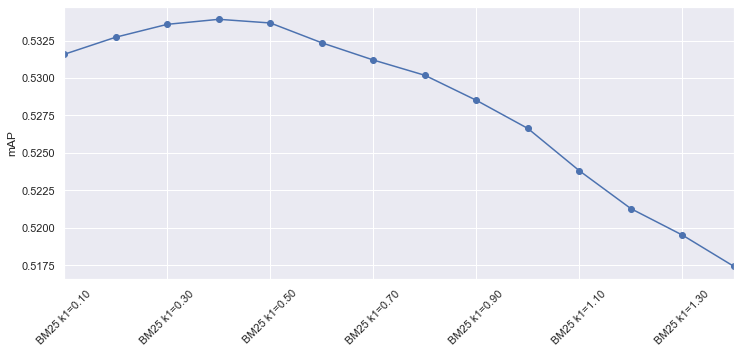

In [14]:
ax = grid_search_result.plot(figsize=(12,5), style="-bo", rot=45, legend=False)
ax.set_ylabel("mAP");